In [25]:
# Import OLID dataset an see whats in it

In [1]:
%run zzz_import_data.ipynb

done with change concat
length df_tweets_all: 101017
0    69738
1    31279
Name: label_all, dtype: int64
done


In [2]:
import numpy as np
import codecs
import unidecode
import re
import ftfy
import pandas as pd
from wordcloud import WordCloud
import emoji
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()
import spacy
import sklearn
from num2words import num2words

nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

plt.style.use('ggplot')

In [3]:
# "If max_cols is exceeded, switch to truncate view"
pd.set_option('display.max_columns', 5400)
# "The maximum width in characters of a column"
pd.set_option('display.max_colwidth', 500)

In [ ]:
df_tweets_all

In [7]:
# before extracting hashtags from tweets, we need to ride of html parts which are 
# in tweets like: &#128111;&#128131;&#128131;
import html
df_tweets_all['tweet_no_html'] = df_tweets_all['tweet'].apply(html.unescape)
#df_tweets_all['tweet_lower'] = df_tweets_all['tweet_no_html'].apply(str.lower)

In [8]:
# before start text cleaning lets look at used hashtags
# function to collect hashtags
def hashtag_extract(x):
    x = x.str.lower()
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [9]:
def emojis_extract(x):
    emojies = []
    # Loop over the words in the tweet
    for i in x:
        em = re.findall(r":(\w+):", i)
        emojies.append(em)
    return emojies

In [10]:
def wrap_points(emoji_list):
    for i, emo  in enumerate(emoji_list):
        #print(i, emo)
        emoji_list[i] = ":" + emo + ":"
    return emoji_list

In [11]:
def wrap_emojies(emoji_list):
    emojies = []
    for emo in emoji_list:
        emojies.append(emoji.emojize(emo))
    return emojies

In [12]:
pattern_retweet = r'^rt '
pattern_char = r'@[A-Za-z0-9_]+'
pattern_html = r'https?://[^ ]+'
pattern_combi = r'|'.join((pattern_char, pattern_html))
pattern_www = r'www.[^ ]+'
negations_dic = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "luv" : "love", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "yo" : "you",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have", "yu" : "you" }
pattern_neg = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [13]:
#(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)

In [14]:
pattern_replace_url = re.compile(r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
old = 'hello world this https://www.gooogle.ch is a sentence www.google.com with google.ch urls http://www.bleuwin.ch'

new_ip = 'replaced_url'

replaced_url = re.sub(pattern_replace_url, new_ip, old)

print('replaced = %s' %(replaced_url))

replaced = hello world this replaced_url is a sentence replaced_url with replaced_url urls replaced_url


In [15]:
def replace_url(input_text):
    replaced_url = re.sub(pattern_replace_url, new_ip, input_text)
    return replaced_url

In [16]:
replace_url(old)

'hello world this replaced_url is a sentence replaced_url with replaced_url urls replaced_url'

In [17]:
def preprocess(input_text):
    #print("raw text: \n{} \n".format(input_text))
    decoded = ftfy.fix_encoding(input_text)
    #print("decoded: \n{} \n".format(decoded))
    #lower = decoded.lower()
    #print("lower: \n{} \n".format(lower))
    #html_free = re.sub(pattern_combi, '', lower)
    #url_free = re.sub(pattern_www, '', html_free)
    #print("html and url free: \n{}\n".format(url_free))
    neg_handled = pattern_neg.sub(lambda x: negations_dic[x.group()], decoded)
    #print("neg_handled: \n{}\n".format(neg_handled))
    demo = emoji.demojize(neg_handled)
    #to do sonderzeichen remove
    # remove special characters, numbers, punctuations aber erst nach rettung der emojies -> new function
    #combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    ## remove twitter handles (@user)
    #combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
    return demo
    #stripped = re.sub(combined_pat, '', bom_removed)
    #stripped = re.sub(www_pat, '', stripped)
    #lower_case = stripped.lower()
    #neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    #letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

In [18]:
def remove_signs(input_text):
    letters_only = re.sub("[^a-zA-Z]", " ", input_text)
    n_rt = re.sub(pattern_retweet, ' ', letters_only)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(n_rt) if len(x) > 1]
    #stemmed = [x for x  in stemmer.stem(words)]
    #stemmed = [stemmer.stem(word) for word in words]
    #print(stemmed)
    #print(words)
    return (" ".join(words)).strip()

In [19]:
def lemm(input_text):
    doc = nlp(input_text)
    # Extract the lemma for each token and join
    return(" ".join([token.lemma_ for token in doc]))

In [20]:
def spacy_cleaner(input_text):
    try:
        decoded = unidecode.unidecode(codecs.decode(input_text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(input_text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([negations_dic[t] if t in negations_dic else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [21]:
def remove_stopwords(input_text, stopword_list):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in input_text.split() if word.lower() not in stopword_list]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
df_tweets_all.sample(10)

In [26]:
df_tweets_all['tweet_tidy_1'] = df_tweets_all['tweet_no_html'].apply(preprocess)

In [31]:
df_tweets_all['tweet_hash'] = hashtag_extract(df_tweets_all['tweet_tidy_1'])

In [32]:
# extracting hashtags from non abusive/racist/sexist tweets
#ht_regular = hashtag_extract(df_tweets_all['tweet_no_html'][df_tweets_all['label_all'] == 0])

ht_regular = df_tweets_all['tweet_hash'][df_tweets_all['label_all'] == 0]
ht_abusive = df_tweets_all['tweet_hash'][df_tweets_all['label_all'] == 1]


"""
# extracting hashtags from abusive/racist/sexist tweets
ht_abusive = hashtag_extract(df_tweets_all['tweet_lower'][df_tweets_all['label_all'] == 1])
ht_sexist = hashtag_extract(df_tweets_all['tweet_lower'][df_tweets_all['label_sex'] == 1])
ht_racist = hashtag_extract(df_tweets_all['tweet_lower'][df_tweets_all['label_rac'] == 1])
"""

# unnesting list
ht_regular = sum(ht_regular,[])
ht_abusive = sum(ht_abusive,[])


In [33]:
nltk.FreqDist(ht_regular)

FreqDist({'mkr': 3975, 'love': 1604, 'positive': 880, 'smile': 580, 'healthy': 576, 'thankful': 497, 'fun': 462, 'life': 429, 'summer': 378, 'cute': 371, ...})

In [34]:
nltk.FreqDist(ht_abusive)

FreqDist({'mkr': 895, 'notsexist': 204, 'trump': 136, 'islam': 133, 'politics': 95, 'allahsoil': 92, 'feminazi': 91, 'libtard': 79, 'sjw': 76, 'liberal': 76, ...})

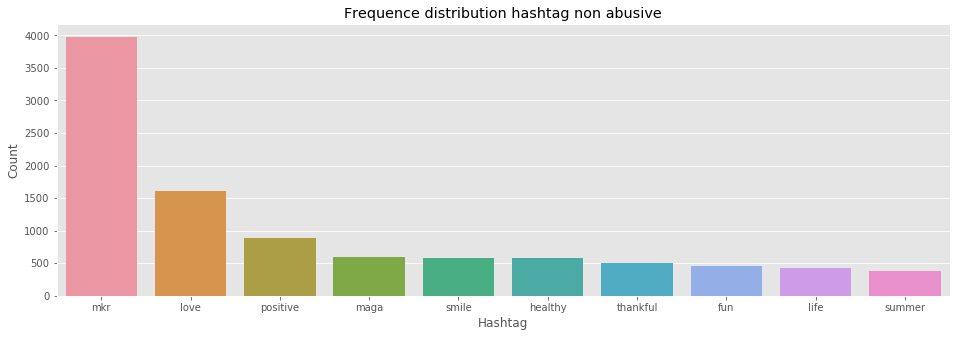

In [52]:
a = nltk.FreqDist(ht_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Frequence distribution hashtag non abusive')
plt.savefig('./diagrams/olid_freq_dist_ht_nonab.png', dpi=200)
plt.show()

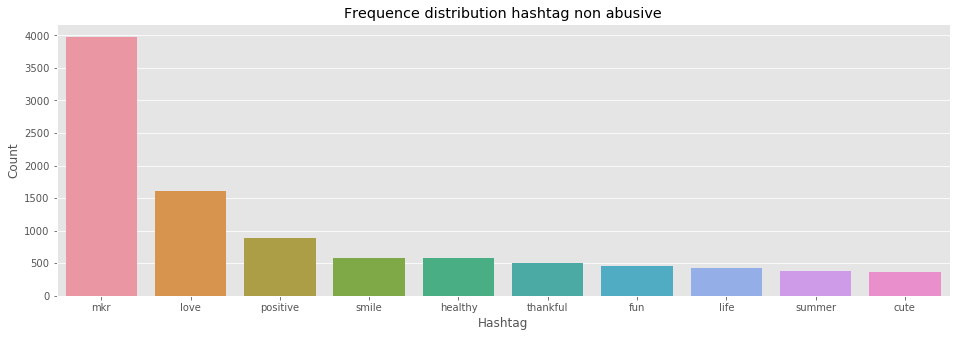

In [35]:
a = nltk.FreqDist(ht_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Frequence distribution hashtag non abusive')
plt.savefig('./diagrams/all_data_freq_dist_ht_nonab.png', dpi=200)
plt.show()

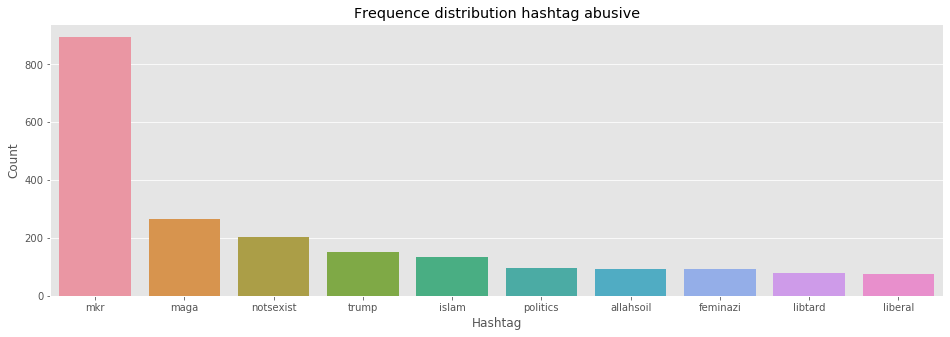

In [53]:
a = nltk.FreqDist(ht_abusive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Frequence distribution hashtag abusive')
plt.savefig('./diagrams/olid_freq_dist_ht_ab.png.png', dpi=200)
plt.show()

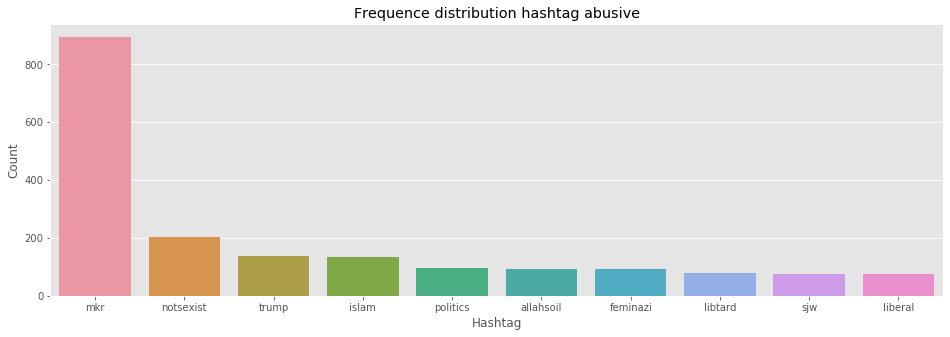

In [36]:
a = nltk.FreqDist(ht_abusive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Frequence distribution hashtag abusive')
plt.savefig('./diagrams/all_data_freq_dist_ht_ab.png.png', dpi=200)
plt.show()

In [37]:
len(df_tweets_all)

101017

In [38]:
df_tweets_all['label_all'].value_counts()

0    69738
1    31279
Name: label_all, dtype: int64

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer='word', ngram_range=(1, 1))
cvec.fit(df_tweets_all.tweet_tidy_1)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [57]:
len(cvec.get_feature_names())

811045

In [58]:
neg_doc_matrix = cvec.transform(df_tweets_all[df_tweets_all.label_all == 1].tweet)
pos_doc_matrix = cvec.transform(df_tweets_all[df_tweets_all.label_all == 0].tweet)

neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)


neg_all = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))


term_freq_df_all = pd.DataFrame([neg_all,pos],columns=cvec.get_feature_names()).transpose()

In [59]:
term_freq_df_all.columns = ['negative', 'positive']
term_freq_df_all['total'] = term_freq_df_all['negative'] + term_freq_df_all['positive']
term_freq_df_all.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
user user user,179,1554,1733
not sexist but,595,25,620
am thankful for,0,429,429
all the time,27,385,412
with all the,16,341,357
i_am positive affirmation,0,352,352
kat and andre,35,304,339
the time in,0,326,326
take with all,0,325,325
model love take,0,325,325


In [60]:
cvec.get_feature_names()

['00 187 00',
 '00 32 00',
 '00 48 00',
 '00 added 10',
 '00 added 30',
 '00 am for',
 '00 and 13',
 '00 and 50',
 '00 bamaman 10',
 '00 bet its',
 '00 bigguy 20',
 '00 blog silver',
 '00 bucks of',
 '00 burg mall',
 '00 cabal 88',
 '00 dh maryland',
 '00 dh na',
 '00 drc florida',
 '00 drops to',
 '00 flax 300',
 '00 florida88 10',
 '00 from vendor',
 '00 gauleiter 20',
 '00 get here',
 '00 hours would',
 '00 html attaboy',
 '00 html cop',
 '00 html executive',
 '00 iconoclast14 32',
 '00 jd hyde',
 '00 lawdog 25',
 '00 level after',
 '00 lives with',
 '00 mark from',
 '00 never knew',
 '00 new total',
 '00 octavian 20',
 '00 of the',
 '00 on profit',
 '00 on their',
 '00 on this',
 '00 online pure',
 '00 open to',
 '00 pm eastern',
 '00 pm to',
 '00 pm today',
 '00 psychological mark',
 '00 scipio americanus',
 '00 shopalyssas upsideofflorida',
 '00 suppo blog',
 '00 total so',
 '00 umberto 25',
 '00 upsideofflorida shopalyssas',
 '00 vonfreyja88 sent',
 '00 warnung wetter',
 '00 wha

In [61]:
term_freq_df_all

,negative,positive,total
00 187 00,0,2,2
00 32 00,0,2,2
00 48 00,0,2,2
00 added 10,0,4,4
00 added 30,0,2,2
...,...,...,...
축하해요 6yearswithinfinite 6th,0,0,0
친구 친스타그램 cat,0,0,0
친스타그램 cat tokyo,0,0,0
호시 hoshi day,0,0,0


In [43]:
term_freq_df_all.columns = ['negative', 'positive']
term_freq_df_all['total'] = term_freq_df_all['negative'] + term_freq_df_all['positive']
term_freq_df_all.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,3250,5824,9074
is,2762,4849,7611
to,2269,4050,6319
you,1887,3628,5515
and,1894,3280,5174
are,1394,2530,3924
of,1374,2460,3834
he,1141,1984,3125
that,1174,1873,3047
not,968,1842,2810


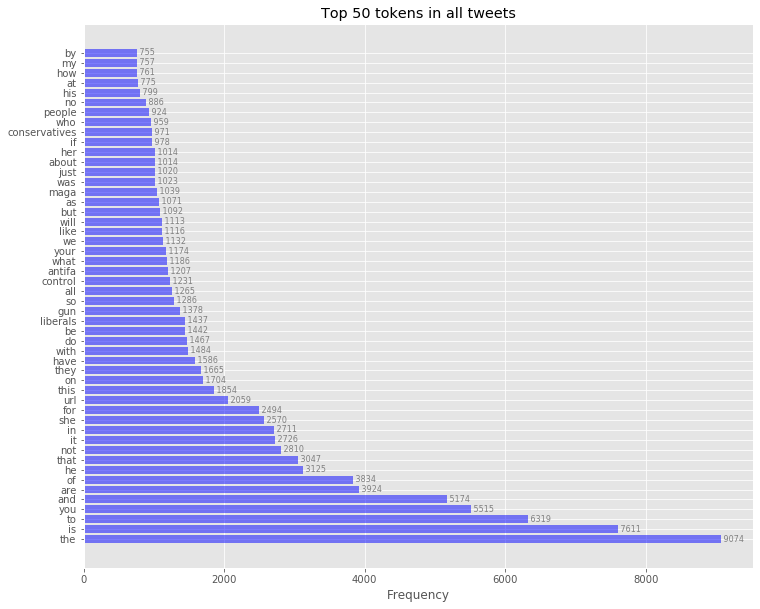

In [44]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50], align='center', alpha=0.5, color = 'blue')
plt.yticks(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50].index,)
plt.xlabel('Frequency')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

    
#plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 tokens in all tweets')
plt.savefig('./diagrams/olid_no_lem_tokens_negative.png', dpi=200)



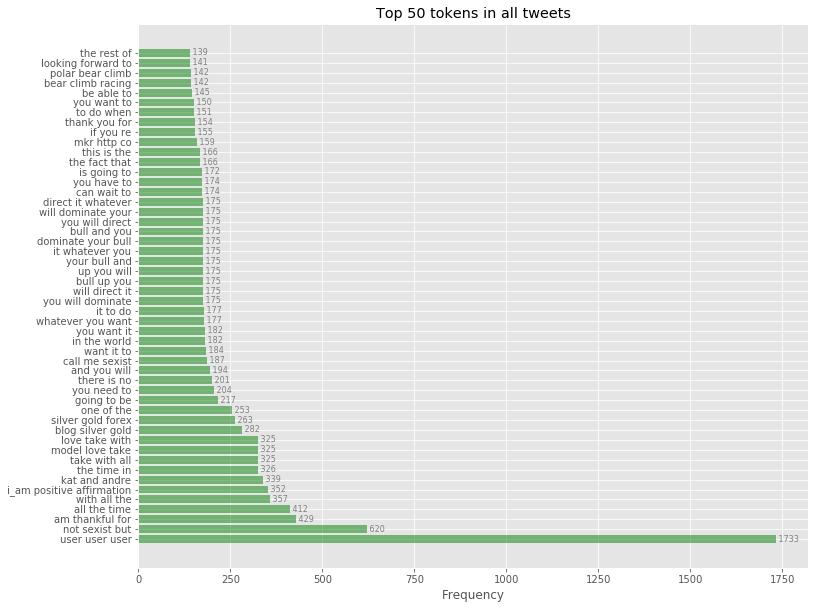

In [63]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50], align='center', 
         alpha=0.5, color = 'green')
plt.yticks(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50].index,)
plt.xlabel('Frequency')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

    
#plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 tokens in all tweets')
plt.savefig('./diagrams/all_data_no_lem_tokens_negative_3_gram.png', dpi=200)

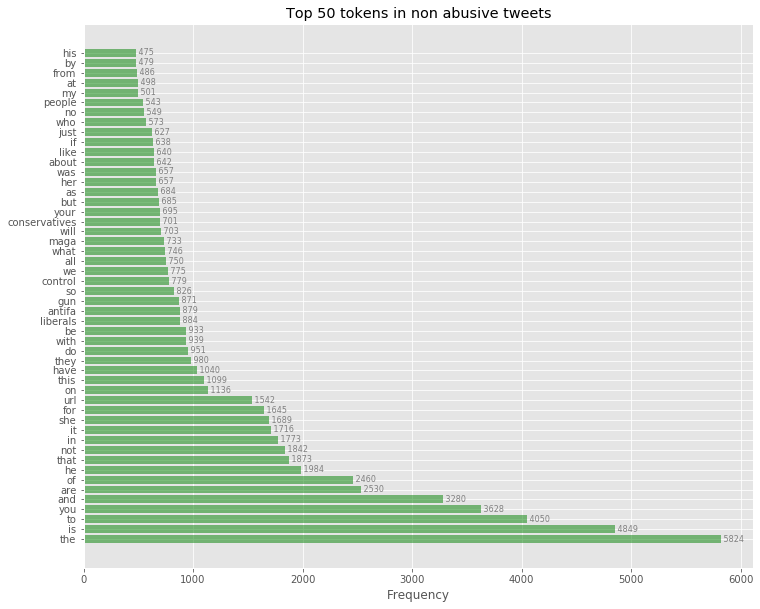

In [45]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50],
         align='center', 
         #width=1,
         alpha=0.5, 
         color = 'green')
ax.invert_yaxis()
ax.invert_xaxis()
plt.yticks(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50].index)
plt.xlabel('Frequency')
#plt.ylabel('Top 50 positive tokens')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

plt.title('Top 50 tokens in non abusive tweets')
plt.savefig('./diagrams/olid_no_lem_tokens_positive', dpi=200)

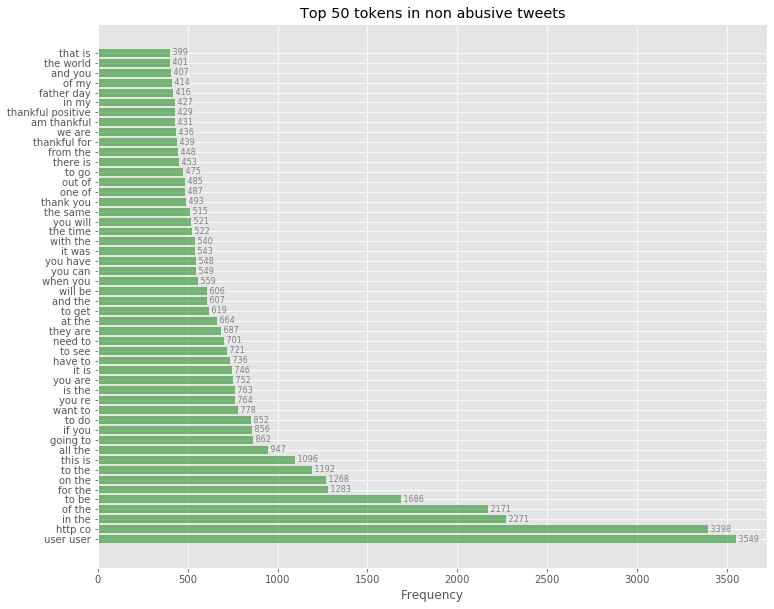

In [51]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50],
         align='center', 
         #width=1,
         alpha=0.5, 
         color = 'green')
ax.invert_yaxis()
ax.invert_xaxis()
plt.yticks(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50].index)
plt.xlabel('Frequency')
#plt.ylabel('Top 50 positive tokens')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

plt.title('Top 50 tokens in non abusive tweets')
plt.savefig('./diagrams/all_data_no_lem_tokens_positive', dpi=200)

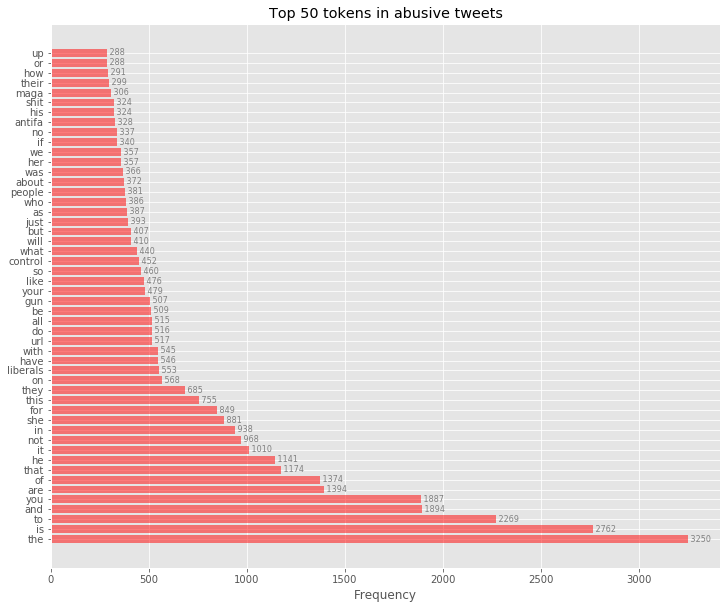

In [46]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50],
         align='center', 
         #width=1,
         alpha=0.5, 
         color = 'red')
ax.invert_yaxis()
ax.invert_xaxis()
plt.yticks(y_pos, term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50].index)
plt.xlabel('Frequency')
#plt.ylabel('Top 50 positive tokens')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

plt.title('Top 50 tokens in abusive tweets')
plt.savefig('./diagrams/olid_no_lem_tokens_negative', dpi=200)

In [47]:
#same with lem, remove punctuiation, etc

In [41]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
nlp.Defaults.stop_words.add("rt")
nlp.Defaults.stop_words.add("it")
nlp.Defaults.stop_words.add("mkr")

In [23]:
from spacy.lang.en.stop_words import STOP_WORDS

In [68]:
STOP_WORDS

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

In [69]:
df_tweets_all['sw_spacy_1_1'] = df_tweets_all['tweet_tidy_1'].apply(remove_stopwords, stopword_list = STOP_WORDS)

In [70]:
cvec_stop_unigram = cvec.fit(df_tweets_all.sw_spacy)


cvec_stop_uni_bigram = CountVectorizer(ngram_range=(1, 1))
cvec_stop_uni_bigram.fit(df_tweets_all.tweet_tidy_1)

#cvec_stop_bigram = CountVectorizer(ngram_range=(2, 2))
#cvec_stop_bigram.fit(df_tweets_all.tweet_tidy_1)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [71]:
df_tweets_all.head()

,tweet,label_all,tweet_no_html,tweet_tidy_1,sw_spacy,sw_spacy_1_1
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user father dysfunctional selfish drags kids dysfunction. #run,@user father dysfunctional selfish drags kids dysfunction. #run
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i cannot use cause they do not offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks #lyft credit use cause offer wheelchair vans pdx. #disapointed #getthanked,@user @user thanks #lyft credit use cause offer wheelchair vans pdx. #disapointed #getthanked
2,bihday your majesty,0,bihday your majesty,bihday your majesty,bihday majesty,bihday majesty
3,#model i love u take with u all the time in urÃ°ÂŸÂ“Â±!!! Ã°ÂŸÂ˜Â™Ã°ÂŸÂ˜ÂŽÃ°ÂŸÂ‘Â„Ã°ÂŸÂ‘Â…Ã°ÂŸÂ’Â¦Ã°ÂŸÂ’Â¦Ã°ÂŸÂ’Â¦,0,#model i love u take with u all the time in urÃ°ÂŸÂ“Â±!!! Ã°ÂŸÂ˜Â™Ã°ÂŸÂ˜ÂŽÃ°ÂŸÂ‘Â„Ã°ÂŸÂ‘Â…Ã°ÂŸÂ’Â¦Ã°ÂŸÂ’Â¦Ã°ÂŸÂ’Â¦,#model i love u take with u all the time in ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets:,#model love u u time ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets:,#model love u u time ur:mobile_phone:!!! :kissing_face_with_smiling_eyes::smiling_face_with_sunglasses::mouth::tongue::sweat_droplets::sweat_droplets::sweat_droplets:
4,factsguide: society now #motivation,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide: society #motivation,factsguide: society #motivation


In [72]:
neg_doc_matrix = cvec_stop_unigram.transform(df_tweets_all[df_tweets_all.label_all == 1].sw_spacy_1_1)
pos_doc_matrix = cvec_stop_unigram.transform(df_tweets_all[df_tweets_all.label_all == 0].sw_spacy_1_1)

neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)


neg_all = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))


term_freq_df_all = pd.DataFrame([neg_all,pos],columns=cvec.get_feature_names()).transpose()

In [73]:
term_freq_df_all

,0,1
00,2,141
000,37,149
0000000000000,1,0
000001,0,2
001,2,3
...,...,...
축하해요,0,2
친구,0,3
친스타그램,0,1
호시,0,1


In [76]:
#term_freq_df_all.columns = ['negative', 'positive']
#term_freq_df_all['total'] = term_freq_df_all['negative'] + term_freq_df_all['positive']
term_freq_df_all.sort_values(by='total', ascending=False).iloc[:25]

,negative,positive,total
user,1866,15765,17631
bitch,8443,80,8523
http,2876,4102,6978
co,3017,3868,6885
like,3298,3484,6782
mkr,895,3985,4880
love,719,3326,4045
face_with_tears_of_joy,3115,769,3884
people,848,2701,3549
day,403,2951,3354


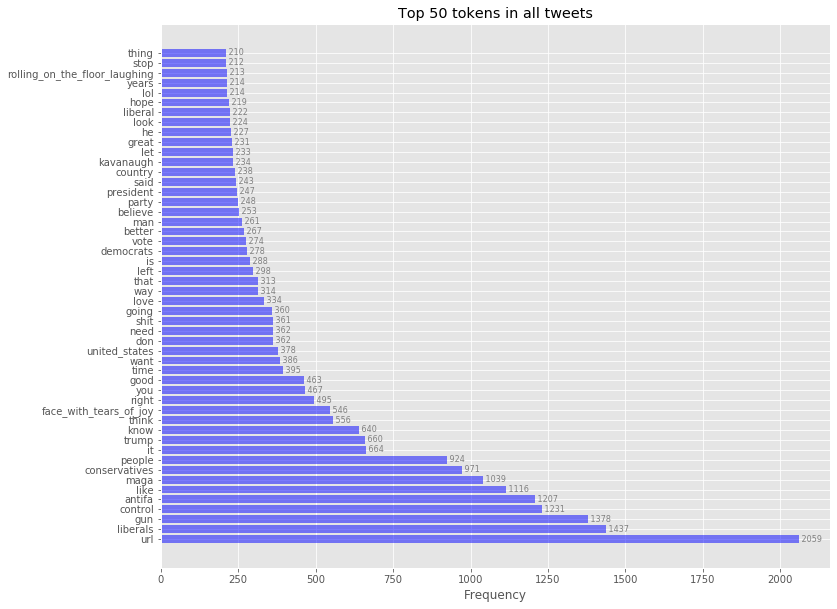

In [64]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50], align='center', alpha=0.5, color = 'blue')
plt.yticks(y_pos, term_freq_df_all.sort_values(by='total', ascending=False)['total'][:50].index,)
plt.xlabel('Frequency')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

    
#plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 tokens in all tweets')
plt.savefig('./diagrams/olid_stop_tokens_negative.png', dpi=200)

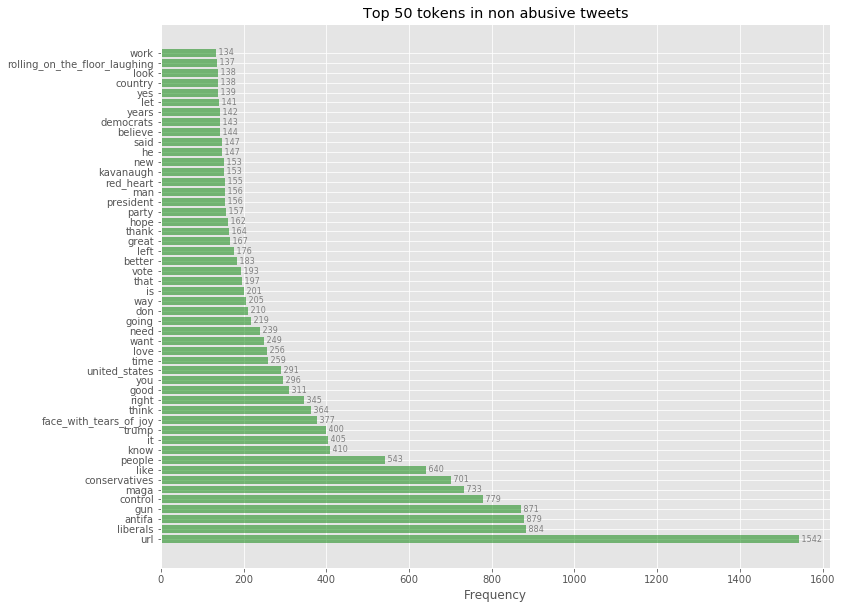

In [65]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50],
         align='center', 
         #width=1,
         alpha=0.5, 
         color = 'green')
ax.invert_yaxis()
ax.invert_xaxis()
plt.yticks(y_pos, term_freq_df_all.sort_values(by='positive', ascending=False)['positive'][:50].index)
plt.xlabel('Frequency')
#plt.ylabel('Top 50 positive tokens')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

plt.title('Top 50 tokens in non abusive tweets')
plt.savefig('./diagrams/olid_stop_tokens_positive', dpi=200)

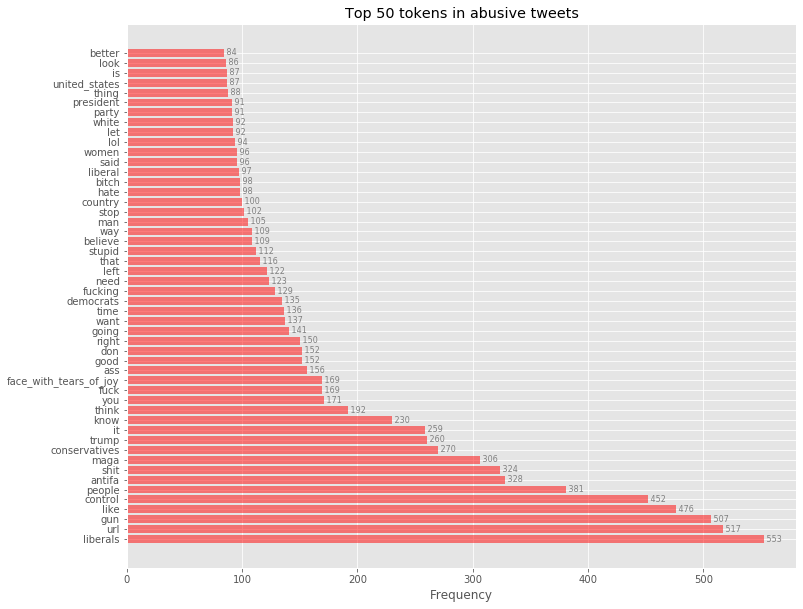

In [66]:
y_pos = np.arange(50)
y = term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50]
plt.figure(figsize=(12,10))
plt.barh(y_pos, term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50],
         align='center', 
         #width=1,
         alpha=0.5, 
         color = 'red')
ax.invert_yaxis()
ax.invert_xaxis()
plt.yticks(y_pos, term_freq_df_all.sort_values(by='negative', ascending=False)['negative'][:50].index)
plt.xlabel('Frequency')
#plt.ylabel('Top 50 positive tokens')

for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), va='center',fontsize=8, color = 'gray')

plt.title('Top 50 tokens in abusive tweets')
plt.savefig('./diagrams/olid_stop_tokens_negative', dpi=200)

In [80]:
df_tweets_all.tweet.str.count("rt ").sum()

2097

In [82]:
df_tweets_all.tweet_tidy_1.str.count("rt ").sum()

2097

In [84]:
df_tweets_all.tweet.str.count("RT ").sum()

11738

In [92]:
df_tweets_all.tweet_tidy_1.str.count("RT ").sum()

11738

In [93]:
len(df_tweets_all)

92853

In [96]:
df_tweets_all.tweet_tidy_1.str.count("@").sum()

95027

In [97]:
df_tweets_all.tweet_tidy_1.str.count("@")

0         1
1         2
2         0
3         0
4         0
         ..
92848     1
92849     0
92850     1
92851     1
92852    16
Name: tweet_tidy_1, Length: 92853, dtype: int64